# Configuration

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
sampling_rate = 100
dataset_path = "ecg_dataset/"

# Preparing data for training

In [3]:
from scripts.data_preparation import get_data_ready_for_training

(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    multi_label_binarizer,
) = get_data_ready_for_training(
    dataset_path=dataset_path,
    sampling_rate=100,
    use_tsfel=True,
    use_temporal_features=True,
    scale_features=True,
    train_val_split=False,
)

Loaded labels
Loaded ECG signals
Encoded labels
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Extracted features
Scaled ECG signals


# Binary Relevance

## SVC

### Hyperparameter selection

In [8]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_parameters = [
    {
        "classifier": [SVC()],
        "classifier__kernel": ["rbf", "linear"],
        "classifier__C": [0.01, 0.1, 1],
    }
]

svc_binary_relevance_classifier_cv = GridSearchCV(
    BinaryRelevance(),
    svc_parameters,
    verbose=2,
    scoring="accuracy",
    error_score="raise",
)

### Model training

In [9]:
svc_binary_relevance_classifier_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  44.4s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  44.6s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  45.5s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  43.9s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  42.5s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  28.2s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  29.1s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  28.8s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  28.4s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  28.1s
[CV] END classifier=SVC()

GridSearchCV(error_score='raise',
             estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [SVC(C=1)],
                          'classifier__C': [0.01, 0.1, 1],
                          'classifier__kernel': ['rbf', 'linear']}],
             scoring='accuracy', verbose=2)

In [46]:
svc_binary_relevance_classifier_cv.best_params_

{'classifier': SVC(C=1), 'classifier__C': 1, 'classifier__kernel': 'rbf'}

In [48]:
best_svc_with_probability = BinaryRelevance(
    classifier=SVC(C=1.0, kernel="rbf", probability=True), require_dense=[False, True]
)

best_svc_with_probability.fit(X_train, y_train)

BinaryRelevance(classifier=SVC(probability=True), require_dense=[False, True])

### Model saving

In [49]:
import os
from joblib import dump

svc_model = best_svc_with_probability
svc_model_filename = "svc.joblib"
output_directory = f"saved_models/svc/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

svc_model_path = os.path.join(output_directory, svc_model_filename)

dump(
    value=svc_model,
    filename=svc_model_path,
)

['saved_models/svc/svc.joblib']

### Model evaluation

In [301]:
y_pred_svc_proba = svc_model.predict_proba(X_test).toarray()

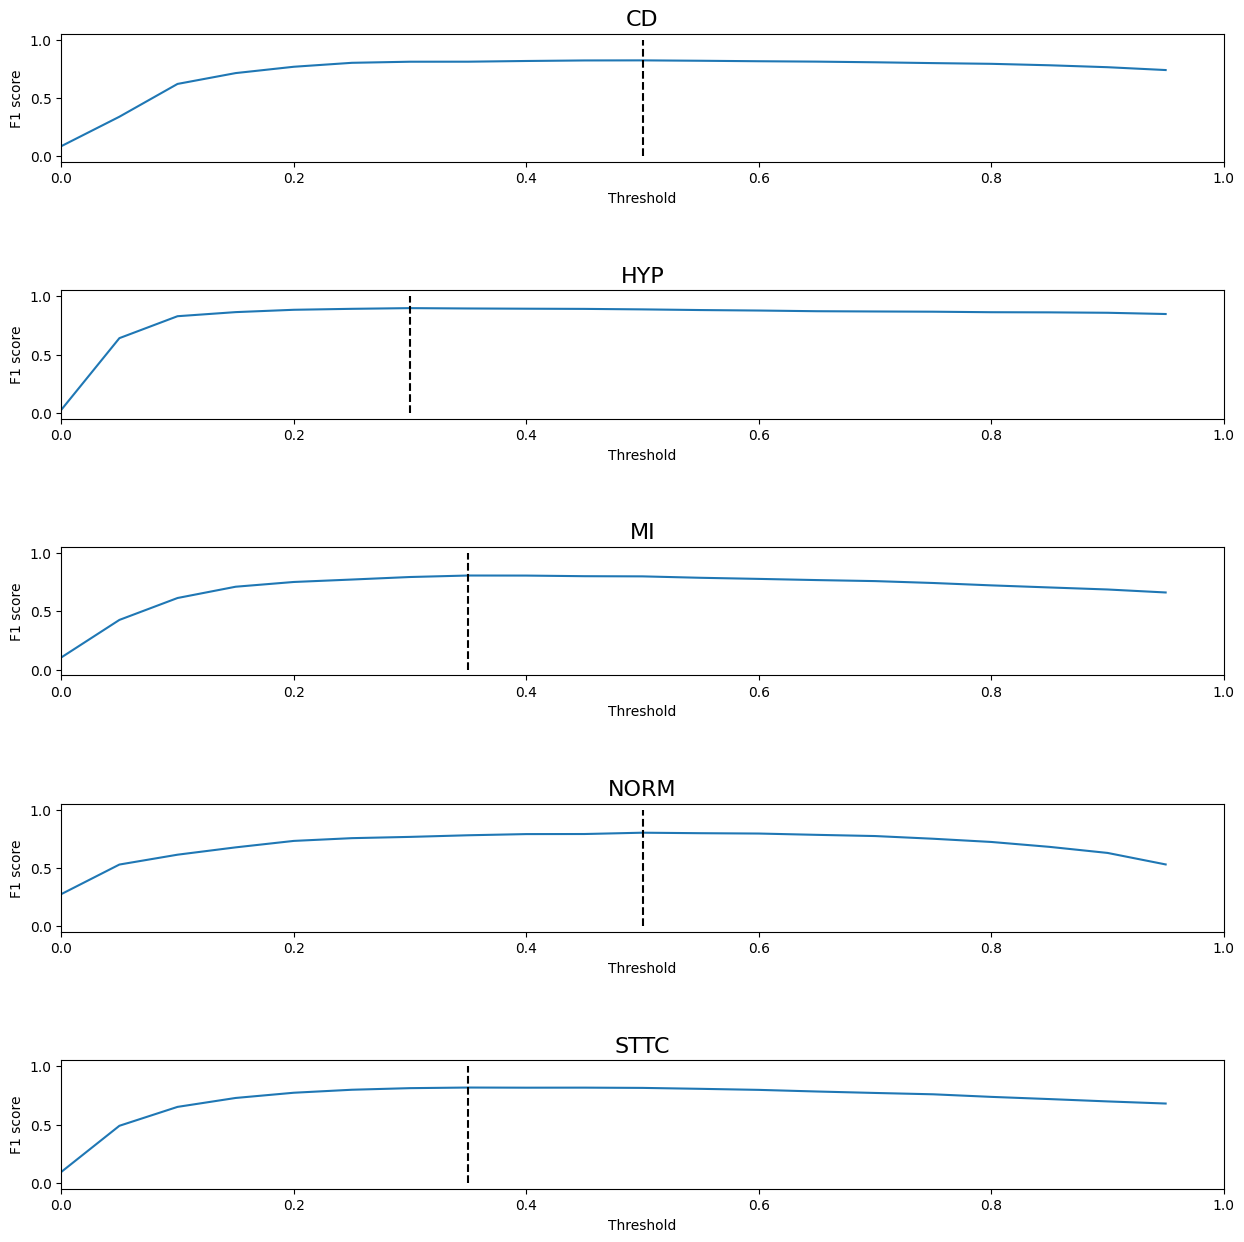

In [302]:
from scripts.data_evaluation import plot_optimal_thresholds

svc_optimal_thresholds = plot_optimal_thresholds(y_test, y_pred_svc_proba)

In [303]:
y_pred_svc = (y_pred_svc_proba >= svc_optimal_thresholds) * 1

In [304]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

file_name = "model_evaluation_optimized.csv"
output_directory = f"saved_data/svc/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

binary_crossentropy_loss_svc = tf.keras.losses.BinaryCrossentropy()
loss_svc = binary_crossentropy_loss_svc(y_test, y_pred_svc_proba)

binary_accuracy_svc = tf.keras.metrics.BinaryAccuracy()
_ = binary_accuracy_svc.update_state(y_test, y_pred_svc)

recall_svc = tf.keras.metrics.Recall()
_ = recall_svc.update_state(y_test, y_pred_svc)

precision_svc = tf.keras.metrics.Precision()
_ = precision_svc.update_state(y_test, y_pred_svc)

auc_svc = tf.keras.metrics.AUC(multi_label=True)
_ = auc_svc.update_state(y_test, y_pred_svc)

svc_model_evaluation = np.array(
    [
        loss_svc.numpy(),
        binary_accuracy_svc.result().numpy(),
        recall_svc.result().numpy(),
        precision_svc.result().numpy(),
        auc_svc.result().numpy(),
    ]
)
svc_model_evaluation = np.round(svc_model_evaluation, 3)
svc_model_evaluation_df = pd.DataFrame(
    data=svc_model_evaluation,
    index=["loss", "binary_accuracy", "recall", "precision", "auc"],
).transpose()
svc_model_evaluation_df.to_csv(os.path.join(output_directory, file_name))

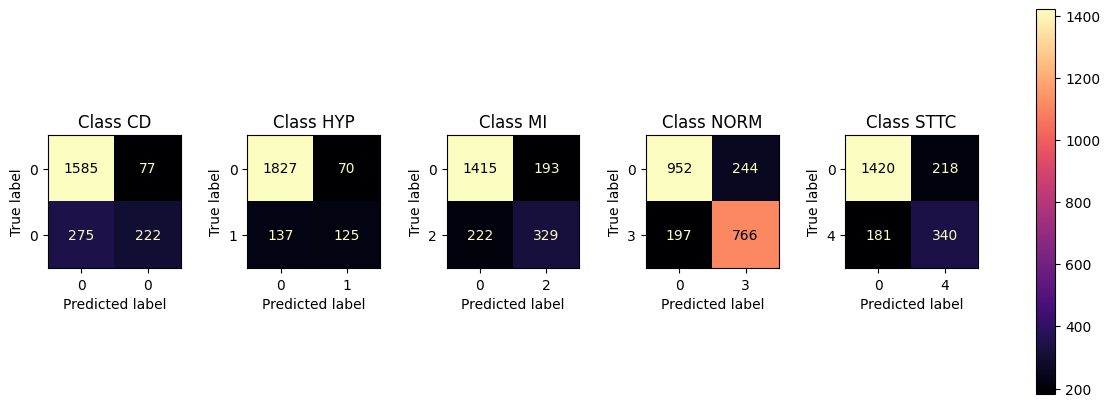

In [305]:
from scripts.data_evaluation import plot_confusion_matrix
import os

file_name = "confusion_matrix_optimized.png"
output_directory = f"saved_images/svc/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

plot_confusion_matrix(
    y_test,
    y_pred_svc,
    multi_label_binarizer.classes_,
    file_path=os.path.join(output_directory, file_name),
)

In [306]:
from sklearn.metrics import classification_report
import pandas as pd

print(
    classification_report(
        y_test, y_pred_svc, target_names=list(multi_label_binarizer.classes_)
    )
)

              precision    recall  f1-score   support

          CD       0.74      0.45      0.56       497
         HYP       0.64      0.48      0.55       262
          MI       0.63      0.60      0.61       551
        NORM       0.76      0.80      0.78       963
        STTC       0.61      0.65      0.63       521

   micro avg       0.69      0.64      0.66      2794
   macro avg       0.68      0.59      0.62      2794
weighted avg       0.69      0.64      0.66      2794
 samples avg       0.64      0.65      0.63      2794



In [307]:
svc_report = classification_report(
    y_test,
    y_pred_svc,
    target_names=list(multi_label_binarizer.classes_),
    output_dict=True,
)
df = pd.DataFrame(svc_report).transpose().round(decimals=3)
df.to_csv(f"saved_data/svc/classification_report_optimized.csv")

## Decision Tree

### Hyperparameter selection

In [30]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_parameters = [
    {
        "classifier": [DecisionTreeClassifier()],
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [3, 5, 10, 15],
    }
]

decision_tree_binary_relevance_classifier_cv = GridSearchCV(
    BinaryRelevance(),
    decision_tree_parameters,
    verbose=2,
    scoring="accuracy",
    error_score="raise",
)

## Model training

In [31]:
decision_tree_binary_relevance_classifier_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=5; total time=   2.9s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=5; total time=   2.9s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=5; total time=   2

GridSearchCV(error_score='raise',
             estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [DecisionTreeClassifier(max_depth=5)],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [3, 5, 10, 15]}],
             scoring='accuracy', verbose=2)

In [42]:
decision_tree_binary_relevance_classifier_cv.best_params_

{'classifier': DecisionTreeClassifier(max_depth=5),
 'classifier__criterion': 'gini',
 'classifier__max_depth': 5}

### Model saving

In [33]:
import os
from joblib import dump

decision_tree_model = decision_tree_binary_relevance_classifier_cv.best_estimator_
decision_tree_model_filename = "decision_tree.joblib"
output_directory = f"saved_models/decision_tree/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

decision_tree_model_path = os.path.join(output_directory, decision_tree_model_filename)

dump(
    value=decision_tree_model,
    filename=decision_tree_model_path,
)

['saved_models/decision_tree/decision_tree.joblib']

### Model evaluation

In [309]:
y_pred_decision_tree_proba = decision_tree_model.predict_proba(X_test).toarray()

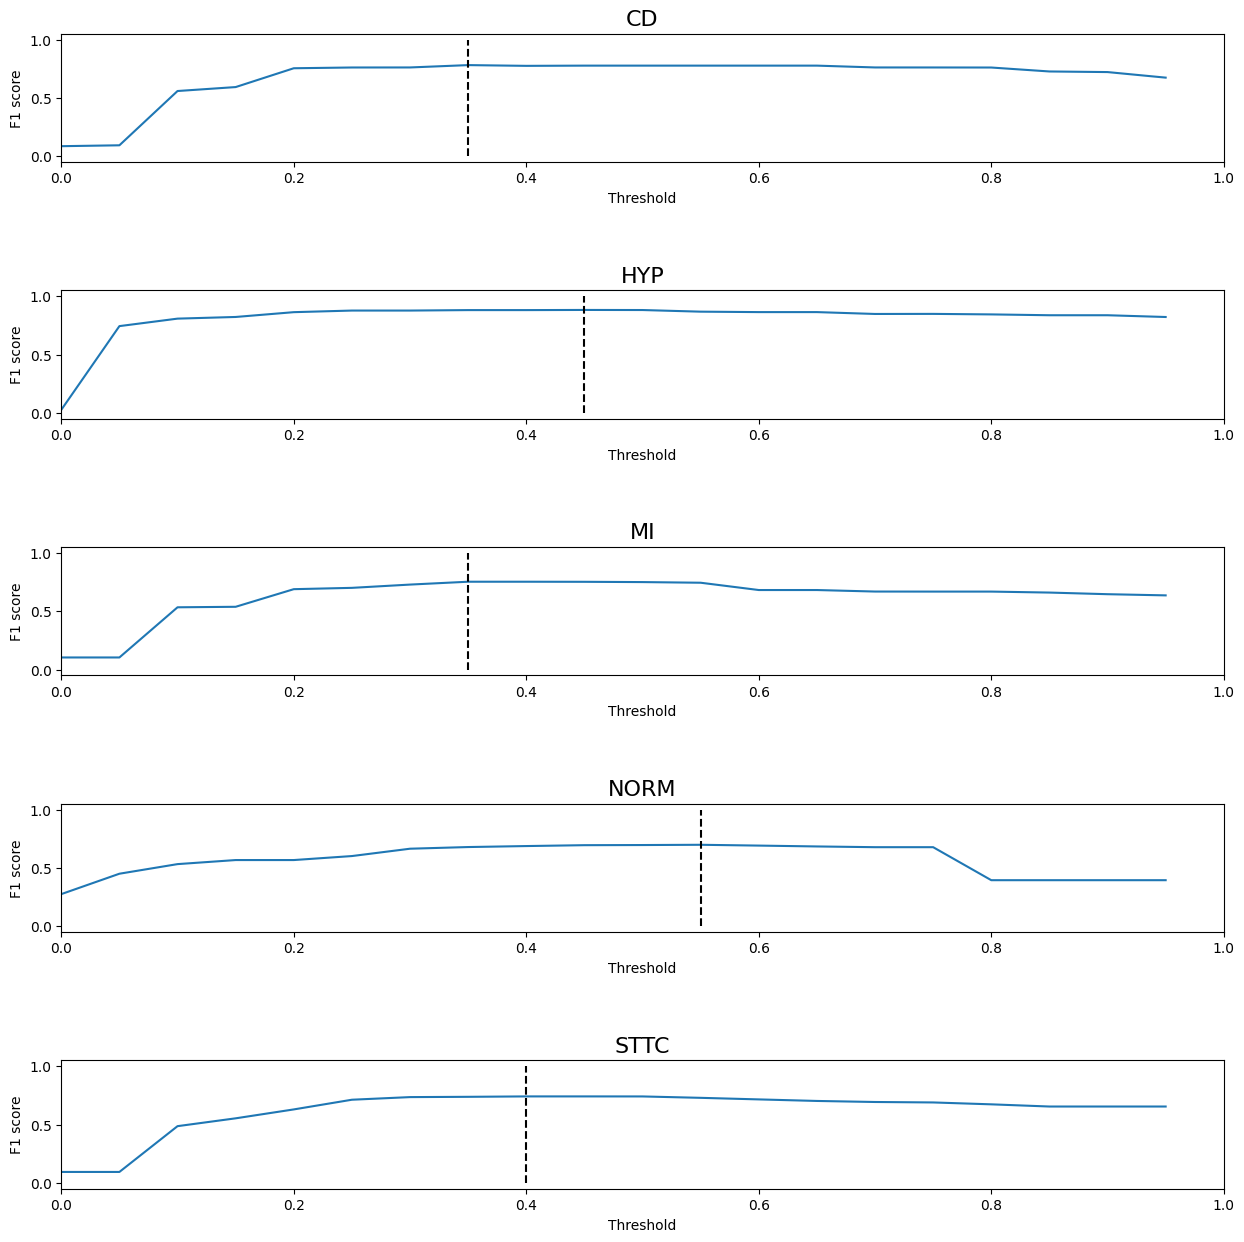

In [310]:
from scripts.data_evaluation import plot_optimal_thresholds

decision_tree_optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_decision_tree_proba
)

In [311]:
y_pred_decision_tree = (
    y_pred_decision_tree_proba >= decision_tree_optimal_thresholds
) * 1

In [312]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

file_name = "model_evaluation_optimized.csv"
output_directory = f"saved_data/decision_tree/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

binary_crossentropy_loss_decision_tree = tf.keras.losses.BinaryCrossentropy()
loss_decision_tree = binary_crossentropy_loss_decision_tree(
    y_test, y_pred_decision_tree_proba
)

binary_accuracy_decision_tree = tf.keras.metrics.BinaryAccuracy()
_ = binary_accuracy_decision_tree.update_state(y_test, y_pred_decision_tree)

recall_decision_tree = tf.keras.metrics.Recall()
_ = recall_decision_tree.update_state(y_test, y_pred_decision_tree)

precision_decision_tree = tf.keras.metrics.Precision()
_ = precision_decision_tree.update_state(y_test, y_pred_decision_tree)

auc_decision_tree = tf.keras.metrics.AUC(multi_label=True)
_ = auc_decision_tree.update_state(y_test, y_pred_decision_tree)

decision_tree_model_evaluation = np.array(
    [
        loss_decision_tree.numpy(),
        binary_accuracy_decision_tree.result().numpy(),
        recall_decision_tree.result().numpy(),
        precision_decision_tree.result().numpy(),
        auc_decision_tree.result().numpy(),
    ]
)
decision_tree_model_evaluation = np.round(decision_tree_model_evaluation, 3)
decision_tree_model_evaluation_df = pd.DataFrame(
    data=decision_tree_model_evaluation,
    index=["loss", "binary_accuracy", "recall", "precision", "auc"],
).transpose()
decision_tree_model_evaluation_df.to_csv(os.path.join(output_directory, file_name))

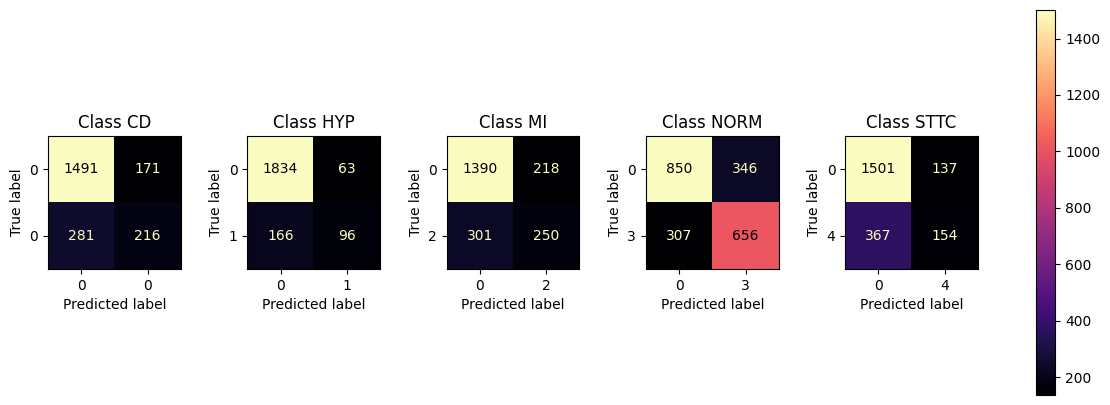

In [313]:
from scripts.data_evaluation import plot_confusion_matrix
import os

file_name = "confusion_matrix_optimized.png"
output_directory = f"saved_images/decision_tree/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

plot_confusion_matrix(
    y_test,
    y_pred_decision_tree,
    multi_label_binarizer.classes_,
    file_path=os.path.join(output_directory, file_name),
)

In [314]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test, y_pred_decision_tree, target_names=list(multi_label_binarizer.classes_)
    )
)

              precision    recall  f1-score   support

          CD       0.56      0.43      0.49       497
         HYP       0.60      0.37      0.46       262
          MI       0.53      0.45      0.49       551
        NORM       0.65      0.68      0.67       963
        STTC       0.53      0.30      0.38       521

   micro avg       0.59      0.49      0.54      2794
   macro avg       0.58      0.45      0.50      2794
weighted avg       0.59      0.49      0.53      2794
 samples avg       0.49      0.51      0.48      2794



In [315]:
import pandas as pd

decision_tree_report = classification_report(
    y_test,
    y_pred_decision_tree,
    target_names=list(multi_label_binarizer.classes_),
    output_dict=True,
)
df = pd.DataFrame(decision_tree_report).transpose().round(decimals=3)
df.to_csv(f"saved_data/decision_tree/classification_report_optimized.csv")

## KNeighborsClassifier

### Hyperparameter selection

In [81]:
from sklearn.neighbors import KNeighborsClassifier

knn_parameters = [
    {
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": [3, 5, 10, 25, 50],
        "classifier__weights": ["uniform", "distance"],
    },
]

knn_binary_relevance_classifier_cv = GridSearchCV(
    BinaryRelevance(),
    knn_parameters,
    verbose=2,
    scoring="accuracy",
    error_score="raise",
)

# Model training

In [82]:
knn_binary_relevance_classifier_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.7s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.7s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.7s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.6s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.7s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=distance; total time=   0.4s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=distance; total time=   0.4s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=distance; tot

GridSearchCV(error_score='raise',
             estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [KNeighborsClassifier(n_neighbors=10,
                                                              weights='distance')],
                          'classifier__n_neighbors': [3, 5, 10, 25, 50],
                          'classifier__weights': ['uniform', 'distance']}],
             scoring='accuracy', verbose=2)

In [85]:
knn_binary_relevance_classifier_cv.best_params_

{'classifier': KNeighborsClassifier(n_neighbors=10, weights='distance'),
 'classifier__n_neighbors': 10,
 'classifier__weights': 'distance'}

### Model saving

In [87]:
import os
from joblib import dump

knn_model = knn_binary_relevance_classifier_cv.best_estimator_
knn_model_filename = "knn.joblib"
output_directory = f"saved_models/knn/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

knn_model_path = os.path.join(output_directory, knn_model_filename)

dump(
    value=knn_model,
    filename=knn_model_path,
)

['saved_models/knn/knn.joblib']

### Model evaluation

In [321]:
y_pred_knn_proba = knn_model.predict_proba(X_test).toarray()

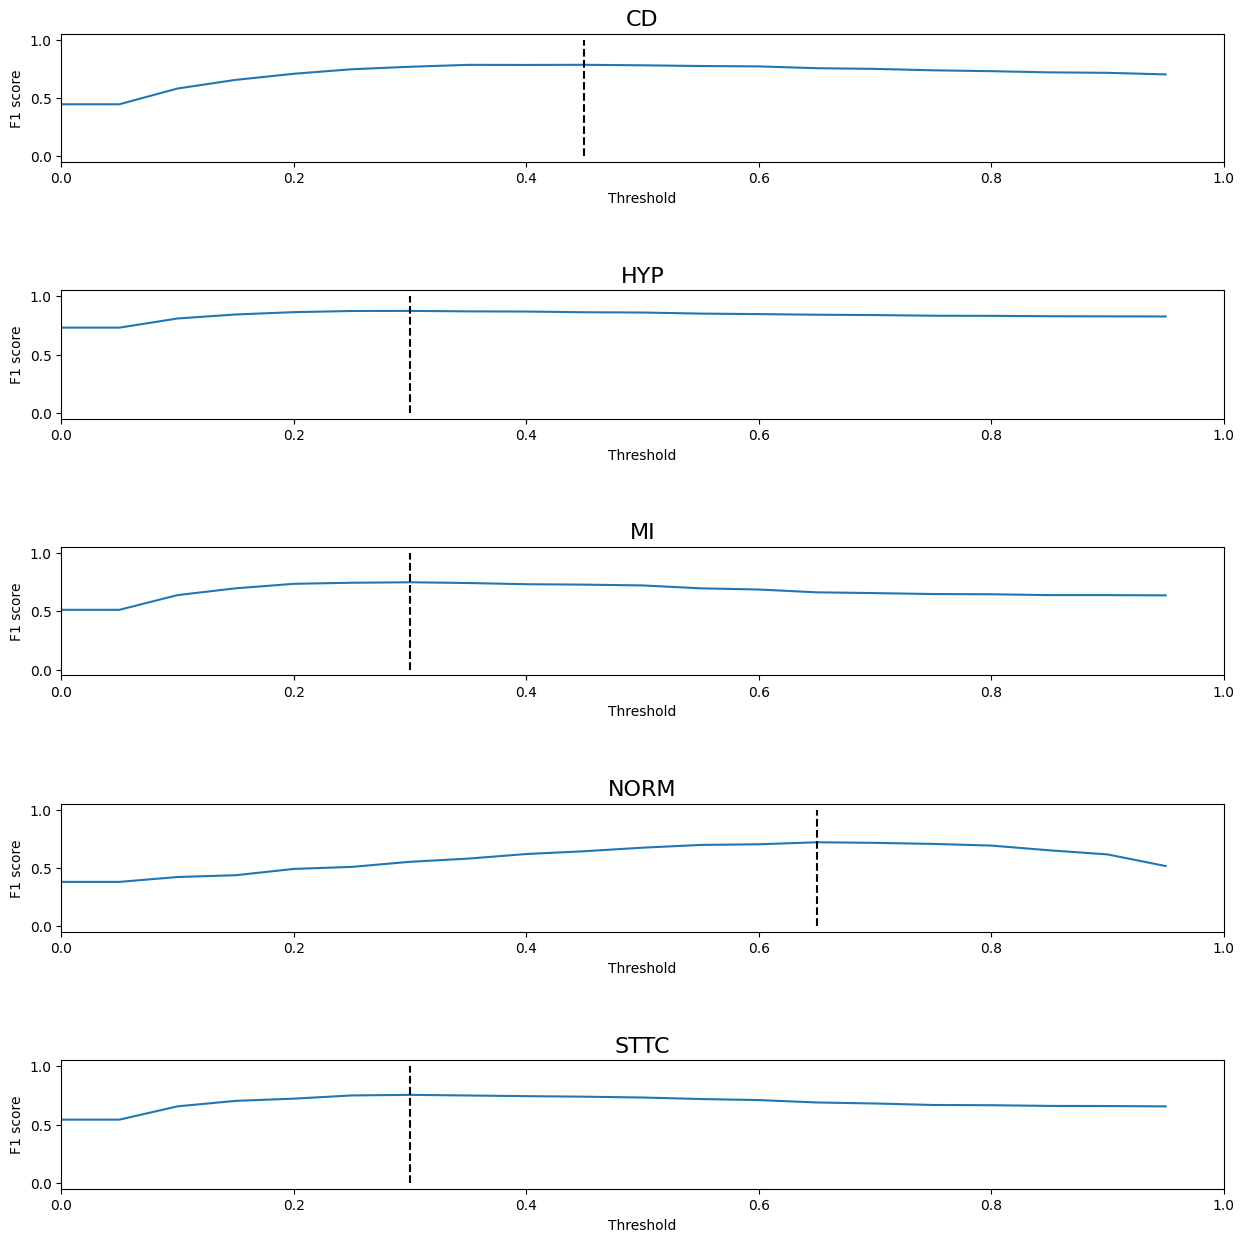

In [322]:
from scripts.data_evaluation import plot_optimal_thresholds

knn_optimal_thresholds = plot_optimal_thresholds(y_test, y_pred_knn_proba)

In [323]:
y_pred_knn = (y_pred_knn_proba > knn_optimal_thresholds) * 1

In [324]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

file_name = "model_evaluation_optimized.csv"
output_directory = f"saved_data/knn/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

binary_crossentropy_loss_knn = tf.keras.losses.BinaryCrossentropy()
loss_knn = binary_crossentropy_loss_knn(y_test, y_pred_knn_proba)

binary_accuracy_knn = tf.keras.metrics.BinaryAccuracy()
_ = binary_accuracy_knn.update_state(y_test, y_pred_knn)

recall_knn = tf.keras.metrics.Recall()
_ = recall_knn.update_state(y_test, y_pred_knn)

precision_knn = tf.keras.metrics.Precision()
_ = precision_knn.update_state(y_test, y_pred_knn)

auc_knn = tf.keras.metrics.AUC(multi_label=True)
_ = auc_knn.update_state(y_test, y_pred_knn)

knn_model_evaluation = np.array(
    [
        loss_knn.numpy(),
        binary_accuracy_knn.result().numpy(),
        recall_knn.result().numpy(),
        precision_knn.result().numpy(),
        auc_knn.result().numpy(),
    ]
)
knn_model_evaluation = np.round(knn_model_evaluation, 3)
knn_model_evaluation_df = pd.DataFrame(
    data=knn_model_evaluation,
    index=["loss", "binary_accuracy", "recall", "precision", "auc"],
).transpose()
knn_model_evaluation_df.to_csv(os.path.join(output_directory, file_name))

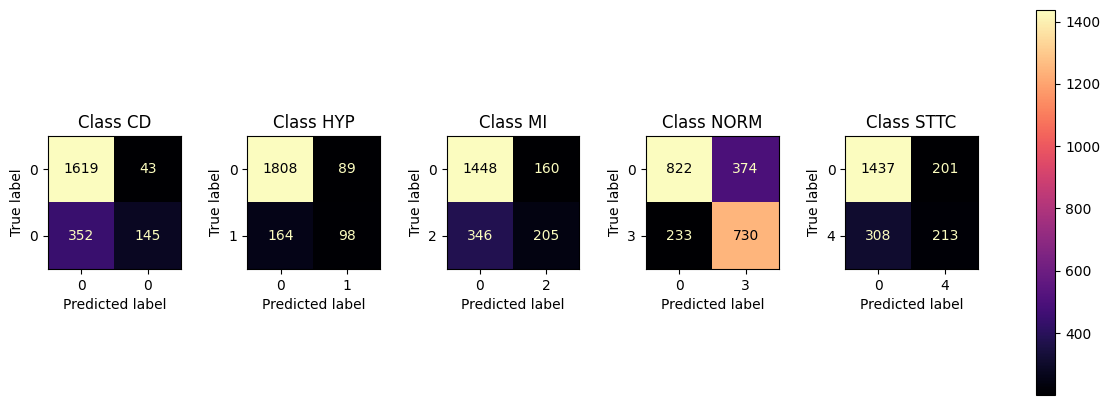

In [325]:
from scripts.data_evaluation import plot_confusion_matrix
import os

file_name = "confusion_matrix_optimized.png"
output_directory = f"saved_images/knn/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

plot_confusion_matrix(
    y_test,
    y_pred_knn,
    multi_label_binarizer.classes_,
    file_path=os.path.join(output_directory, file_name),
)

In [326]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test, y_pred_knn, target_names=list(multi_label_binarizer.classes_)
    )
)

              precision    recall  f1-score   support

          CD       0.77      0.29      0.42       497
         HYP       0.52      0.37      0.44       262
          MI       0.56      0.37      0.45       551
        NORM       0.66      0.76      0.71       963
        STTC       0.51      0.41      0.46       521

   micro avg       0.62      0.50      0.55      2794
   macro avg       0.61      0.44      0.49      2794
weighted avg       0.62      0.50      0.53      2794
 samples avg       0.53      0.52      0.51      2794



In [327]:
import pandas as pd

knn_report = classification_report(
    y_test,
    y_pred_knn,
    target_names=list(multi_label_binarizer.classes_),
    output_dict=True,
)
df = pd.DataFrame(knn_report).transpose().round(decimals=3)
df.to_csv(f"saved_data/knn/classification_report_optimized.csv")

## RandomForestClassifier

### Hyperparameter selection

In [39]:
from sklearn.ensemble import RandomForestClassifier

random_forest_parameters = [
    {
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": [64, 100, 128, 200],
    },
]

random_forest_binary_relevance_classifier_cv = GridSearchCV(
    BinaryRelevance(),
    random_forest_parameters,
    verbose=2,
    scoring="accuracy",
    error_score="raise",
)

# Model training

In [40]:
random_forest_binary_relevance_classifier_cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  45.2s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  45.9s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  45.9s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  45.9s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  46.8s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.2min
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.2min
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.2min
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.2min
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.

GridSearchCV(error_score='raise',
             estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [RandomForestClassifier(n_estimators=200)],
                          'classifier__n_estimators': [64, 100, 128, 200]}],
             scoring='accuracy', verbose=2)

In [93]:
random_forest_binary_relevance_classifier_cv.best_params_

{'classifier': RandomForestClassifier(n_estimators=200),
 'classifier__n_estimators': 200}

### Model saving

In [94]:
import os
from joblib import dump

random_forest_model = random_forest_binary_relevance_classifier_cv.best_estimator_
random_forest_model_filename = "random_forest.joblib"
output_directory = f"saved_models/random_forest/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

random_forest_model_path = os.path.join(output_directory, random_forest_model_filename)

dump(
    value=random_forest_model,
    filename=random_forest_model_path,
)

['saved_models/random_forest/random_forest.joblib']

### Model evaluation

In [329]:
y_pred_random_forest_proba = random_forest_model.predict_proba(X_test).toarray()

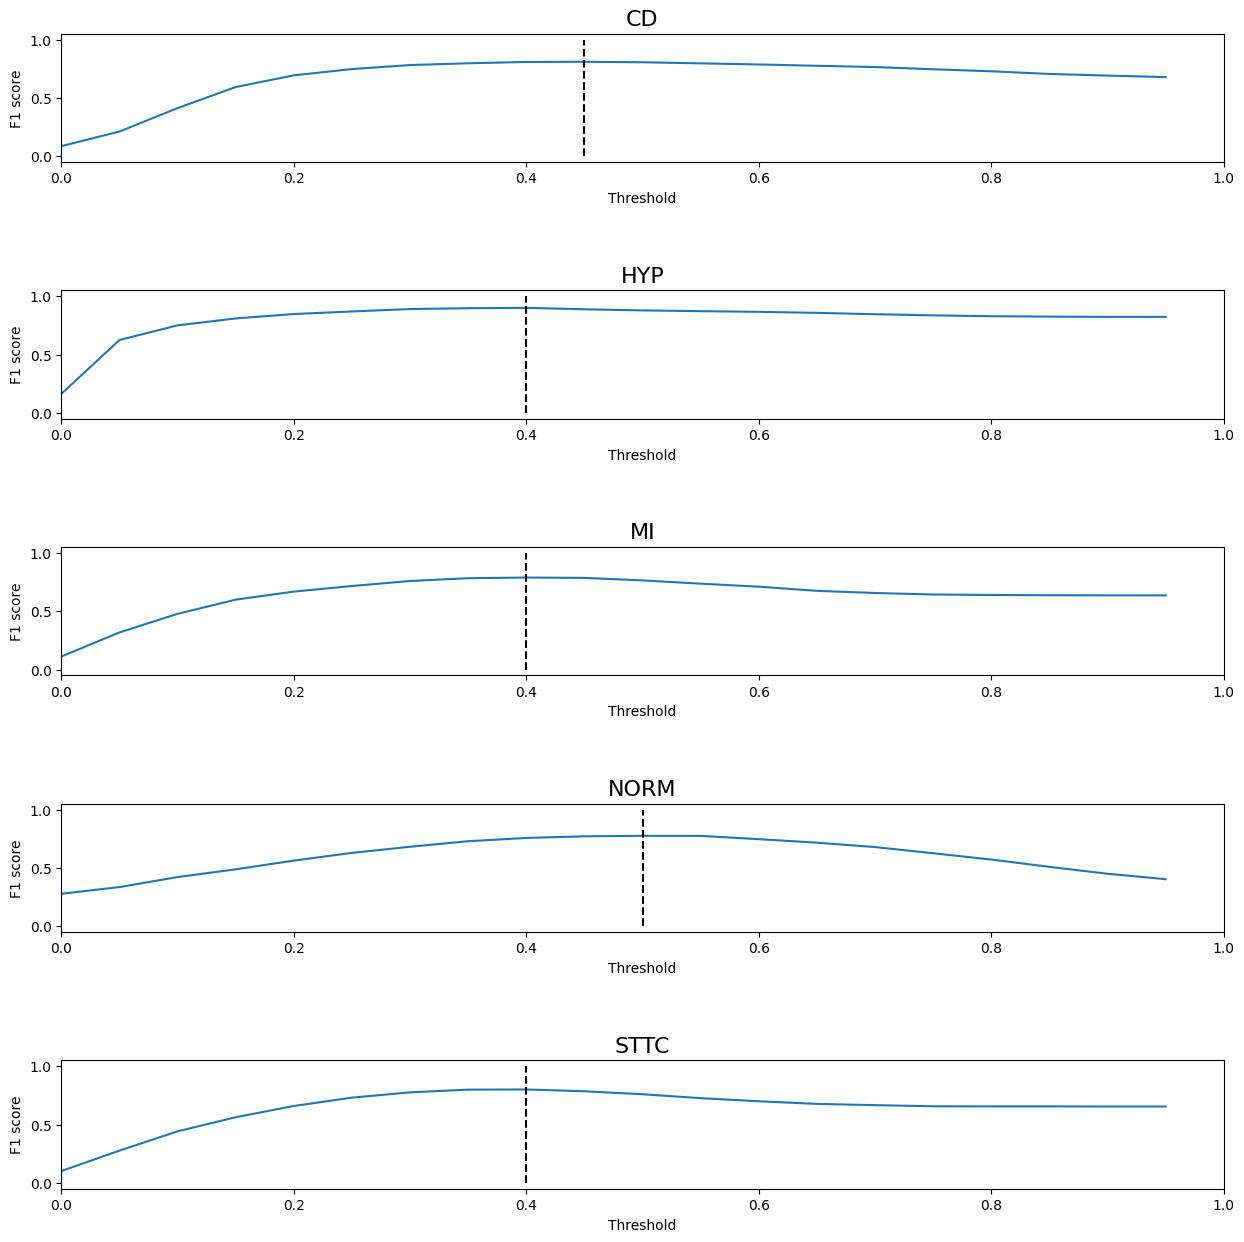

In [330]:
from scripts.data_evaluation import plot_optimal_thresholds

random_forest_optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_random_forest_proba
)

In [331]:
y_pred_random_forest = (
    y_pred_random_forest_proba > random_forest_optimal_thresholds
) * 1

In [332]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

file_name = "model_evaluation_optimized.csv"
output_directory = f"saved_data/random_forest/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

binary_crossentropy_loss_random_forest = tf.keras.losses.BinaryCrossentropy()
loss_random_forest = binary_crossentropy_loss_random_forest(
    y_test, y_pred_random_forest_proba
)

binary_accuracy_random_forest = tf.keras.metrics.BinaryAccuracy()
_ = binary_accuracy_random_forest.update_state(y_test, y_pred_random_forest)

recall_random_forest = tf.keras.metrics.Recall()
_ = recall_random_forest.update_state(y_test, y_pred_random_forest)

precision_random_forest = tf.keras.metrics.Precision()
_ = precision_random_forest.update_state(y_test, y_pred_random_forest)

auc_random_forest = tf.keras.metrics.AUC(multi_label=True)
_ = auc_random_forest.update_state(y_test, y_pred_random_forest)

random_forest_model_evaluation = np.array(
    [
        loss_random_forest.numpy(),
        binary_accuracy_random_forest.result().numpy(),
        recall_random_forest.result().numpy(),
        precision_random_forest.result().numpy(),
        auc_random_forest.result().numpy(),
    ]
)
random_forest_model_evaluation = np.round(random_forest_model_evaluation, 3)
random_forest_model_evaluation_df = pd.DataFrame(
    data=random_forest_model_evaluation,
    index=["loss", "binary_accuracy", "recall", "precision", "auc"],
).transpose()
random_forest_model_evaluation_df.to_csv(os.path.join(output_directory, file_name))

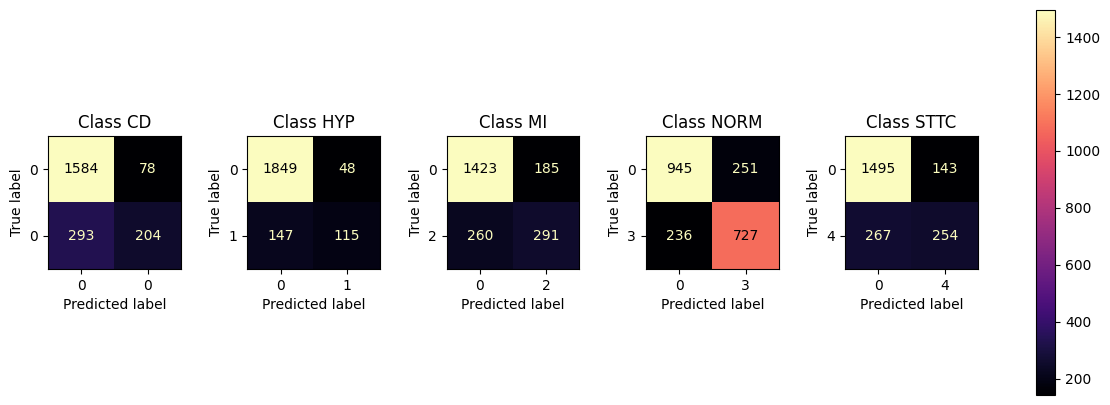

In [333]:
from scripts.data_evaluation import plot_confusion_matrix
import os

file_name = "confusion_matrix_optimized.png"
output_directory = f"saved_images/random_forest/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

plot_confusion_matrix(
    y_test,
    y_pred_random_forest,
    multi_label_binarizer.classes_,
    file_path=os.path.join(output_directory, file_name),
)

In [334]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test, y_pred_random_forest, target_names=list(multi_label_binarizer.classes_)
    )
)

              precision    recall  f1-score   support

          CD       0.72      0.41      0.52       497
         HYP       0.71      0.44      0.54       262
          MI       0.61      0.53      0.57       551
        NORM       0.74      0.75      0.75       963
        STTC       0.64      0.49      0.55       521

   micro avg       0.69      0.57      0.63      2794
   macro avg       0.68      0.52      0.59      2794
weighted avg       0.69      0.57      0.62      2794
 samples avg       0.58      0.58      0.56      2794



In [335]:
import pandas as pd

random_forest_report = classification_report(
    y_test,
    y_pred_random_forest,
    target_names=list(multi_label_binarizer.classes_),
    output_dict=True,
)
df = pd.DataFrame(random_forest_report).transpose().round(decimals=3)
df.to_csv(f"saved_data/random_forest/classification_report_optimized.csv")